*Copyright 2024 Google LLC.*

*Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at*

     http://www.apache.org/licenses/LICENSE-2.0

*Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.*

# End to End Example

[![Open in Colab](https://img.shields.io/badge/Open_in_Colab-blue?style=flat&logo=google%20colab&labelColor=grey)](https://colab.research.google.com/github/google-marketing-solutions/fractional_uplift/blob/main/examples/end_to_end_example.ipynb)  
[![Open in Github](https://img.shields.io/badge/Open_in_Github-blue?style=flat&logo=Github&labelColor=grey)](https://github.com/google-marketing-solutions/fractional_uplift/blob/main/examples/end_to_end_example.ipynb)  
[![Open in NBViewer](https://img.shields.io/badge/Open_in_NBViewer-blue?style=flat&logo=jupyter&labelColor=grey)](https://nbviewer.org/github/google-marketing-solutions/fractional_uplift/blob/main/examples/end_to_end_example.ipynb)

Welcome to the end to end example of Fractional Uplift. This is a simple demo using the [Criteo dataset](https://ailab.criteo.com/criteo-uplift-prediction-dataset/) which will showcase the basic usage of Fractional Uplift for building uplift models to create user-targeted promotions.

## Fractional uplift modelling overview

The fractional uplift package is useful in cases where the cost of a promotion is not deterministic. This is a common scenario, for example if you offer a user a coupon with certain conditions (for example it is only valid for on certain items), then you don't know when you offer the coupon how much it will cost you - it depends what the user buys.

In this case, regular uplift modeling can be sub-optimal, because it will model the incrementality of the coupon but not the cost. Fractional uplift models are designed to optimise for multiple metrics, so can perform better.

Regular uplift models are designed to estimate the conditional average treatment effect of a single metric (e.g. conversion rate or spend):

$$
f_\text{uplift}(X) = \text{CATE}_y(X) = E[y | T=1, X] - E[y | T=0, X]
$$

Fractional uplift models estimate a composite of multiple CATE estimates across multiple metrics, and combine them into a single composite score as follows:

$$
f_\text{fractional uplift}(X) =
\begin{cases}
    \frac{\text{CATE}_\alpha (X)}{\text{CATE}_\beta(X) - \frac{\text{CATE}_\gamma (X)}{\delta}},& \text{CATE}_\beta(X) > \frac{\text{CATE}_\gamma (X)}{\delta}\\
    \infty,              & \text{otherwise}
\end{cases}
$$

Where:

- $\alpha$ is the "Maximize KPI" - the KPI to be maximized
- $\beta$ is the "Constraint KPI" - the KPI that acts as a constraint, and we want to keep as low as possible.
- $\gamma$ is the "Constraint Offset KPI" - the KPI that can offset the constraint. This is optional.
- $\delta$ is the "Constraint Offset Scale" - a constant which scales the constraint_offset_kpi. Not needed if there is no constraint_offset_kpi.

What we set these different KPIs to be will determine what the fractional uplift model optimises for, and you'll see a few different examples later in the notebook.

In [ ]:
# Install the packages if necessary
! pip install -q fractional-uplift pandas numpy statsmodels tensorflow tensorflow_decision_forests matplotlib

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

import tensorflow as tf  # Needs to be imported so that tensorflow decision forests runs in eager mode


try:
  import google.colab
  google.colab.data_table.enable_dataframe_formatter()
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
import tensorflow_decision_forests as tfdf
import fractional_uplift as fr

In [ ]:
# Hide the keras training logs - they are very noisy for tfdf
tfdf.keras.set_training_logs_redirection(False)

## Load the Criteo data

The [Criteo dataset](https://ailab.criteo.com/criteo-uplift-prediction-dataset/) is a public dataset for benchmarking uplift modeling methods. The authors describe it as follows:

> This dataset is constructed by assembling data resulting from several incrementality tests, a particular randomized trial procedure where a random part of the population is prevented from being targeted by advertising. It consists of 25M rows, each one representing a user with 11 features, a treatment indicator and 2 labels (visits and conversions).

It is designed for the standard uplift modeling problem where you have a single KPI (in this case conversions or views) that you want to target. However, in this notebook we would like to model a more complex use-case for uplift modeling, where you are offering promotions to users. In this case we need to calculate things like RoI, so we need to add two extra columns: Spend and Cost.

The spend is the amount the customer spends if they convert, and is generated as a random function of the features. The cost is assumed to be a discount or voucher, so there is only a cost if the user converts. The percentage cost is also modelled from the features, and there is only a cost when the user is treated and converts.

In [ ]:
criteo = fr.example_data.CriteoWithSyntheticCostAndSpend.load()

In [ ]:
criteo.train_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,treatment_propensity,cost_percentage,spend,cost,sample_weight
44,12.616365,10.059654,8.964588,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0.85,0.000000,0.000000,0.000000,100.0
187,12.616365,10.059654,8.904597,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0.85,0.000000,0.000000,0.000000,100.0
484,22.377238,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0.85,0.000000,0.000000,0.000000,100.0
528,12.616365,10.059654,8.350682,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,16.226044,5.300375,-0.168679,1,0,0.85,0.000000,0.000000,0.000000,100.0
1108,14.617627,10.059654,8.489929,3.907662,13.253813,4.115453,-2.411115,4.833815,3.809530,42.176324,5.737292,-0.560340,1,1,0.85,0.090777,36.459294,3.309655,1.0


## Experiment Analysis

First let's just analyze the performance of the treatment overall, as a regular A/B test. We are offering coupons to customers, which give them a discount on their purchases, so let's evaluate the incremental RoI (iRoI) of the campaign. This is defined as:

$$
\text{iRoI} = \frac{\text{Spend}_\text{T=1} - \text{Spend}_\text{T=0}}{\text{Cost}_\text{T=1}}
$$

Below we estimate the iRoI with a confidence interval, using ordinary least squares and the delta method.

**Warning: The formula for estimating the confidence interval on iRoI with the delta method is slightly wrong - it ignores the correlation between the spend and cost of the treated users. This means the confidence interval we calculate will be too wide. But this is not the focus of this notebook, so for simplicity I will leave it as it is.**

In [ ]:
def perform_ols(input_df: pd.DataFrame, target: str) -> tuple[float, float]:
  """Performs ordinary least squares regression using statsmodels.

  This regresses the target on the treatment indicator - it's the equivalent to performing a t-test.

  Args:
    input_df: The data top use for the regression.

  Returns:
    A tuple, where the first element is the effect size and the second element is the standard
    error on the effect size.
  """
  Y = input_df[target].values
  X = input_df[["treatment"]]
  X = sm.add_constant(X)
  model = sm.OLS(Y,X)
  results = model.fit()

  effect_size = results.params["treatment"]
  se = results.HC0_se["treatment"]
  return effect_size, se


def estimate_incremental_roi(data: pd.DataFrame) -> tuple[float, float, float]:
  """Estimates the incremental RoI and uncertainty with the delta method.

  This is not exact as it does not take into account the correlation between spend and cost
  in the treated users. In reality the width of the confidence intervals would be smaller, so this is a
  conservative estimate.

  Args:
    data: Data to use for the analysis.

  Returns:
    The incrmental RoI, lower bound and upper bound.
  """
  effect_size_spend, spend_se = perform_ols(data, "spend")
  avg_cost = data.loc[data["treatment"]==1, "cost"].mean()
  cost_se = data.loc[data["treatment"]==1, "cost"].std() / np.sqrt(np.sum(data["treatment"]))

  inc_roi = effect_size_spend / avg_cost
  inc_roi_se = np.abs(inc_roi) * np.sqrt(
      spend_se**2 / effect_size_spend**2 + cost_se**2 / avg_cost**2
  )

  inc_roi_lb = inc_roi - 2.0*inc_roi_se
  inc_roi_ub = inc_roi + 2.0*inc_roi_se

  return inc_roi, inc_roi_lb, inc_roi_ub

inc_roi, inc_roi_lb, inc_roi_ub = estimate_incremental_roi(criteo.data)
print(f"Incremental RoI = {inc_roi:.2f} [Lower Bound={inc_roi_lb:.2f}, Upper Bound={inc_roi_ub:.2f}]")

Incremental RoI = 0.97 [Lower Bound=0.90, Upper Bound=1.03]


Looks like the treatment is having a clear and measurable impact (the lower bound of the iRoI is considerably larger than 0), but also the cost is high, meaning the RoI is not conclusively above 1.0 and we could be losing money with this promotion.

This is the ideal scenario for uplift modeling! By targeting the promotion at the correct users we should be able to achieve a higher iRoI.

## Uplift Modelling

Now I will train a variety of uplift models to optimise this promotion campaign.

### Distillation

The uplift models used throughout this notebook are meta learners, meaning they are compositions of multiple machine learning models. For example, the T-Learner described below is two models, one predicting the treatment response, and one predicting the control response.

Because there are multiple models, this can add latency overhead if used directly in production. Therefore, all the meta learners in the fractional uplift package provide a distill method, which will create a single model that approximates the full uplift model. In the examples below I will show the performance of both the distilled model and the non-distilled model.

### A note on model tuning

I am not performing any model tuning in this notebook, I'm just using the default hyperparameters for the tensorflow decision forest GBM. In reality, you will want to use some hyperparameter tuning to improve the performance of the models.

### The T-Learner (baseline)

First I want to use an existing uplift modeling methodology, to have a baseline to compare the fractional uplift models with.

A simple and reasonably well performing uplift model is the T-learner. This uplift model estimates the absolute uplift for a single KPI, by training two models: one model is trained on the control data, and another on the treatment data. The uplift is the difference between the two model predictions. Check out [this site](https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html) for a nice explanation of the T-Learner.

I will train two T-Learners here, one estimating the uplift on conversion rate, and another on spend.

In [ ]:
test_dataset = fr.datasets.PandasDataset(
    features_data=criteo.test_data[criteo.features]
)
distill_dataset = fr.datasets.PandasDataset(
    features_data=criteo.distill_data[criteo.features]
)

In [ ]:
def get_base_regressor():
  # This is just an example regressor. For a real project, I would recommend
  # using hyperparamter tuning to find the optimal model, using the tuning argument.
  # See the tensorflow decision forest documentation for more details.
  return fr.base_models.TensorflowDecisionForestRegressor(
      tfdf.keras.GradientBoostedTreesModel,
      init_args=dict(verbose=0, max_depth=6, num_trees=300, shrinkage=0.1),
      fit_args=dict(verbose=0)
  )

In [ ]:
for target in ["conversion", "spend"]:
  print(f"\nTraining the {target} T-learner\n")

  train_data = fr.datasets.PandasTrainData(
      features_data=criteo.train_data[criteo.features],
      maximize_kpi=criteo.train_data[target].values,
      is_treated=criteo.train_data["treatment"].values,
      treatment_propensity=criteo.train_data["treatment_propensity"].values,
      sample_weight=criteo.train_data["sample_weight"].values,
      shuffle_seed=1234
  )

  t_learner = fr.meta_learners.TLearner(get_base_regressor())
  t_learner.fit(train_data)

  distill_t_learner = get_base_regressor()
  t_learner.distill(distill_dataset, distill_t_learner)

  criteo.test_data[f"{target}_t_learner_score"] = t_learner.predict(test_dataset)
  criteo.test_data[f"{target}_t_learner_score_distill"] = distill_t_learner.predict(test_dataset)


Training the conversion T-learner

21/21 [==============================] - 1s 11ms/step

Training the spend T-learner

21/21 [==============================] - 0s 10ms/step


In [ ]:
def plot_cumulative_incrementality(
    ax: plt.Axes,
    results_data: pd.DataFrame,
    model_names: dict[str, str],
    x_col: str,
    y_col: str,
    title: str = "",
    x_label: str | None = None,
    y_label: str | None = None,
    x_format: str = "{0}",
    y_format: str = "{0}",
    order_col: str = "share_targeted",
    random_baseline_name: str = "random",
    x_lim: list[float] | None = None,
    y_lim: list[float] | None = None,
    show_legend: bool = True,
  ) -> None:
  """Plots the cumulative incrementality of any x and y metrics."""

  baselines_data = results_data.loc[results_data.name == random_baseline_name].copy().sort_values(order_col)
  models_data = results_data.loc[results_data.name.isin(model_names)].copy().sort_values(order_col)

  raw_model_names = list(model_names.keys())
  clean_model_names = list(model_names.values())

  ax.plot(baselines_data[x_col], baselines_data[y_col], color="k", lw=1, label="")

  for raw_model_name, model_results in models_data.groupby("name"):

    if raw_model_name.endswith("_distill"):
      raw_model_name = raw_model_name.removesuffix("_distill")
      label = ""
      line_style = "--"
    else:
      label = model_names[raw_model_name]
      line_style = "-"

    color = f"C{raw_model_names.index(raw_model_name)}"
    ax.plot(model_results[x_col], model_results[y_col], color=color, lw=1.5, label=label, ls=line_style)

  if x_lim is not None:
    ax.set_xlim(x_lim)
  if y_lim is not None:
    ax.set_ylim(y_lim)

  ax.set_xlabel(x_label or x_col)
  ax.set_ylabel(y_label or y_col)
  ax.set_title(title)

  ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: x_format.format(x)))
  ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, pos: y_format.format(y)))

  # Add legend
  if show_legend:
    handles, labels = ax.get_legend_handles_labels()
    handles.extend([
        Line2D([0], [0], alpha=0.0),
        Line2D([0], [0], color="0.7", lw=1.5, ls="-"),
        Line2D([0], [0], color="0.7", lw=1.5, ls="--")
    ])
    labels.extend([
        "",
        "Full model",
        "Distilled model"
    ])
    model_legend = ax.legend(
        handles=handles,
        labels=labels,
        loc='upper left',
        bbox_to_anchor=(1, 1)
    )

  del(baselines_data)
  del(models_data)

Now I can evaluate the two T-Learners. I do this by plotting the incremental spend and incremental conversions as a function of the share of users targeted by the model. If the model was selecting users at random, then if we target 50% of the users, we would expect 50% of the incremental conversions and spend. But if the uplift model is working, then targeting 50% of the users should deliver more than 50% of the incremental conversions and spend. The uplift curves below allow us to visualise this for the whole range of percentages of users targeted.

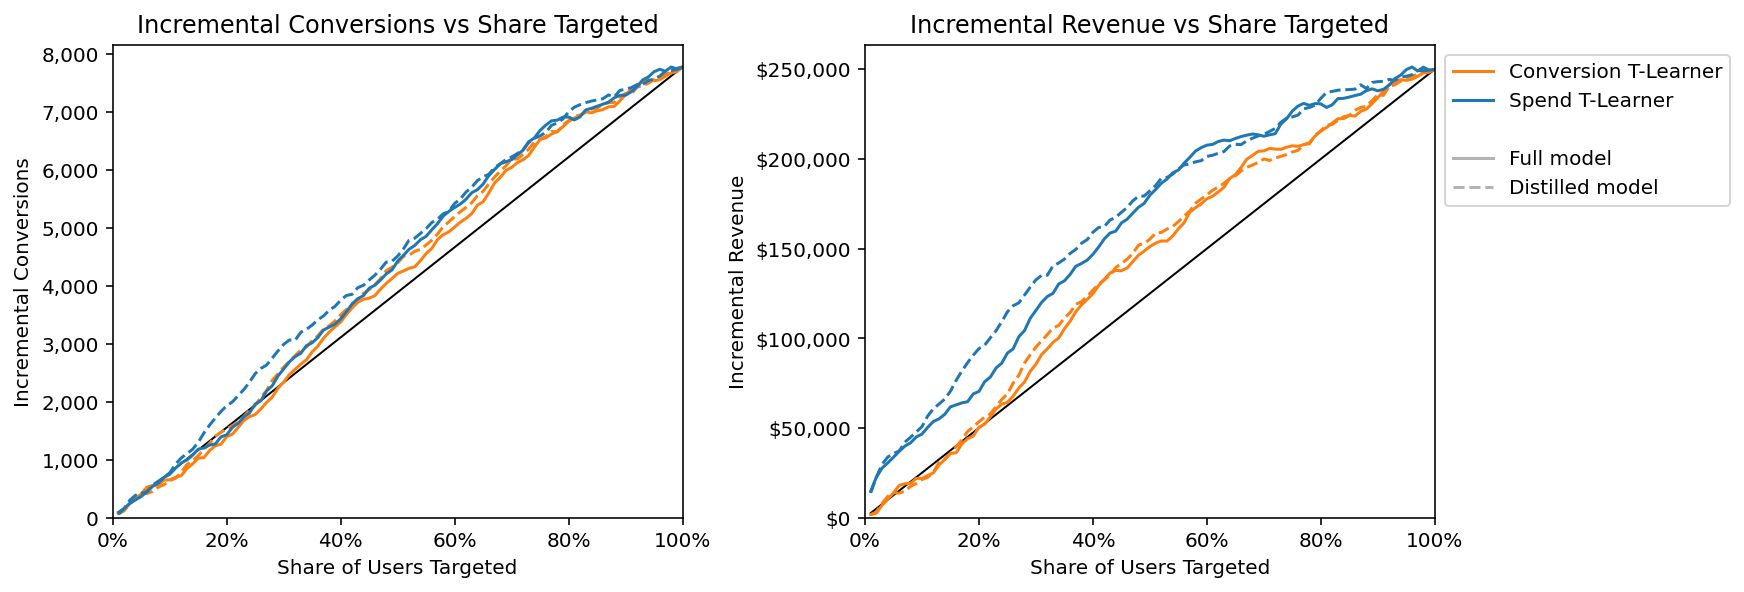

In [ ]:
evaluator = fr.evaluate.UpliftEvaluator(
    metric_cols=["spend", "conversion"],
    is_treated_col="treatment",
    treatment_propensity_col="treatment_propensity",
    effect_type=fr.EffectType.ATE
)

models = {
    "spend_t_learner_score": "Spend T-Learner",
    "conversion_t_learner_score": "Conversion T-Learner",
    "spend_t_learner_score_distill": "Spend T-Learner",
    "conversion_t_learner_score_distill": "Conversion T-Learner",
}

results = evaluator.evaluate(criteo.test_data, score_cols=list(models.keys()))

fig, axs = plt.subplots(ncols=2, figsize=(12, 4), constrained_layout=True)

plot_cumulative_incrementality(
    axs[0],
    results,
    title="Incremental Conversions vs Share Targeted",
    model_names=models,
    x_col="share_targeted",
    y_col="conversion__inc_cum",
    x_label="Share of Users Targeted",
    y_label="Incremental Conversions",
    x_format="{:.0%}",
    y_format="{:,.0f}",
    show_legend=False,
    x_lim=[0, 1],
    y_lim=[0, None]
)

plot_cumulative_incrementality(
    axs[1],
    results,
    title="Incremental Revenue vs Share Targeted",
    model_names=models,
    x_col="share_targeted",
    y_col="spend__inc_cum",
    x_label="Share of Users Targeted",
    y_label="Incremental Revenue",
    x_format="{:.0%}",
    y_format="${:,.0f}",
    x_lim=[0, 1],
    y_lim=[0, None]
)

plt.show()

It looks like the uplift models are working. The uplift curves are mostly above the random baseline (black line), meaning that they are doing better than selecting users at random. Both models do okay for optimisng for incremental conversions, but the spend T-Learner clearly performs better at finding incremental revenue, which is expected as the conversion T-Learner has no idea about the spend.

But the question is - is this the right way to evaluate our uplift models? The answer is, usually no, because targeting based on a percentage of users doesn't equate to the same percentage of cost. Perhaps those are also the most expensive users to target?

In the next sections we'll evaluate the uplift models with some different and more realistic marketing objectives, and then see how well these T-Learners perform compared with the appropriate fractional uplift model.

## Fractional uplift modelling



### Objective 1: Minimum Cost per Incremental Acquisition (CPiA)

The first marketing objective we will look at is minimising the cost per incremental acquisition (where in this case an acquisition is a conversion). This means that we want to spend the least possible per incremental conversion we get. The CPiA is defined as:

$$
\text{CPiA} = \frac{N_{\text{convert}, \, T=1} - N_{\text{convert}, \, T=0}}{\text{Cost}_{T=1}}
$$

#### Fractional uplift model

We optimise for CPiA by setting the following metrics for our fractional uplift model:

* Maximize KPI ($\alpha$) = Conversion
* Constraint KPI ($\beta$) = Cost
* Constraint Offset KPI ($\gamma$) = *Not used*

This fractional uplift model is trained below:

In [ ]:
train_data = fr.datasets.PandasTrainData(
    features_data=criteo.train_data[criteo.features],
    maximize_kpi=criteo.train_data["conversion"].values,
    constraint_kpi=criteo.train_data["cost"].values,
    is_treated=criteo.train_data["treatment"].values,
    treatment_propensity=criteo.train_data["treatment_propensity"].values,
    sample_weight=criteo.train_data["sample_weight"].values,
    shuffle_seed=1234
)
fractional_t_learner = fr.meta_learners.FractionalLearner(get_base_regressor())
fractional_t_learner.fit(train_data)

distill_fractional_t_learner = get_base_regressor()
fractional_t_learner.distill(distill_dataset, distill_fractional_t_learner)

criteo.test_data[f"cpia_score"] = fractional_t_learner.predict(test_dataset)
criteo.test_data[f"cpia_score_distill"] = distill_fractional_t_learner.predict(test_dataset)

21/21 [==============================] - 0s 10ms/step


#### Evaluation

The lowest CPiA will correspond to the case where we get the most incremental conversions for the lowest cost. We will evaluate this in two ways:

1. Plot the incremental conversions as a function of total cost. The best model is the one with the highest incremental conversions for the same cost.
2. Plot the CPiA as a function of incremental conversions. The best model is the one with the lowest CPiA for the same incremental conversions.

These metrics are calculated using the UpliftEvaluator below.

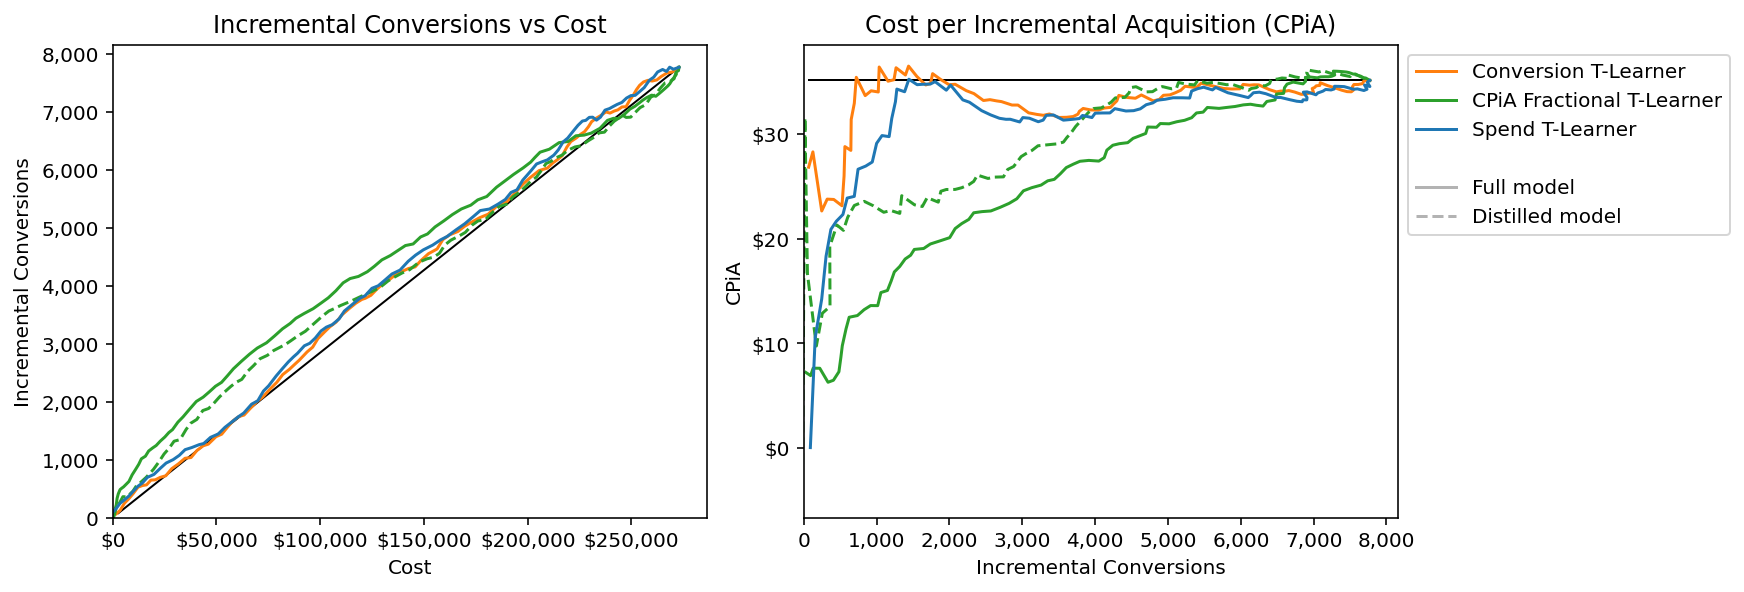

In [ ]:
class CPIAUpliftEvaluator(fr.evaluate.UpliftEvaluator):
  def __init__(self, **kwargs):
    kwargs["metric_cols"] = ["spend", "conversion", "cost"]
    super().__init__(**kwargs)

  def _calculate_composite_metrics(self, data: pd.DataFrame) -> pd.DataFrame:
    data["cpia__inc_cum"] = data["cost__inc_cum"] / data["conversion__inc_cum"]
    data["cpia__inc"] = data["cost__inc"] / data["conversion__inc"]
    return data

evaluator = CPIAUpliftEvaluator(
    is_treated_col="treatment",
    treatment_propensity_col="treatment_propensity",
    effect_type=fr.EffectType.ATE
)

models = {
    "spend_t_learner_score": "Spend T-Learner",
    "conversion_t_learner_score": "Conversion T-Learner",
    "cpia_score": "CPiA Fractional T-Learner",
    "cpia_score_distill": "CPiA Fractional T-Learner",
}

results = evaluator.evaluate(criteo.test_data, score_cols=list(models.keys()))

fig, axs = plt.subplots(ncols=2, figsize=(12, 4), constrained_layout=True)

plot_cumulative_incrementality(
    axs[0],
    results,
    title="Incremental Conversions vs Cost",
    model_names=models,
    x_col="cost__inc_cum",
    y_col="conversion__inc_cum",
    x_label="Cost",
    y_label="Incremental Conversions",
    x_format="${:,.0f}",
    y_format="{:,.0f}",
    x_lim=[0, None],
    y_lim=[0, None],
    show_legend=False
)

plot_cumulative_incrementality(
    axs[1],
    results,
    title="Cost per Incremental Acquisition (CPiA)",
    model_names=models,
    x_col="conversion__inc_cum",
    y_col="cpia__inc_cum",
    x_label="Incremental Conversions",
    y_label="CPiA",
    x_format="{:,.0f}",
    y_format="${:,.0f}",
    x_lim=[0, None]
)

plt.show()

Here you can see that the fractional uplift model clearly outperforms the regular uplift models. It achieves a much lower CPiA and much more incremental conversions for the same cost, while the T-Learners actually increase the CPiA in some cases. This is because the T-Learners have no awareness of the cost, and they end up targeting high cost users, which even though they have high incrementality, end up delivering a worse CPiA.

### Objective 2: Maximum iRoI

What if instead of CPiA, we want to look at the revenue we get. Not every conversion is equal, some will deliver more revenue than others. If we want to generate the highest possible incremental revenue (spend) at lowest possible cost, we are optimising for the maximum iRoI:

$$
\text{iRoI} = \frac{\text{Spend}_\text{T=1} - \text{Spend}_\text{T=0}}{\text{Cost}_\text{T=1}}
$$

#### Fractional uplift model

We optimise for iRoI by setting the following metrics for our fractional uplift model:

* Maximize KPI ($\alpha$) = Spend
* Constraint KPI ($\beta$) = Cost
* Constraint Offset KPI ($\gamma$) = *Not used*

This fractional uplift model is trained below:

In [ ]:
train_data = fr.datasets.PandasTrainData(
    features_data=criteo.train_data[criteo.features],
    maximize_kpi=criteo.train_data["spend"].values,
    constraint_kpi=criteo.train_data["cost"].values,
    is_treated=criteo.train_data["treatment"].values,
    treatment_propensity=criteo.train_data["treatment_propensity"].values,
    sample_weight=criteo.train_data["sample_weight"].values,
    shuffle_seed=1234
)
fractional_t_learner = fr.meta_learners.FractionalLearner(get_base_regressor())
fractional_t_learner.fit(train_data)

distill_fractional_t_learner = get_base_regressor()
fractional_t_learner.distill(distill_dataset, distill_fractional_t_learner)

criteo.test_data[f"roi_score"] = fractional_t_learner.predict(test_dataset)
criteo.test_data[f"roi_score_distill"] = distill_fractional_t_learner.predict(test_dataset)

21/21 [==============================] - 0s 10ms/step


#### Evaluation

The highest iRoI will correspond to the case where we get the most incremental revenue for the lowest cost. We will evaluate this in two ways:

1. Plot the incremental revenue as a function of total cost. The best model is the one with the highest incremental revenue for the same cost.
2. Plot the iRoI as a function of incremental revenue. The best model is the one with the highest iRoI for the same incremental revenue.

These metrics are calculated using the UpliftEvaluator below.

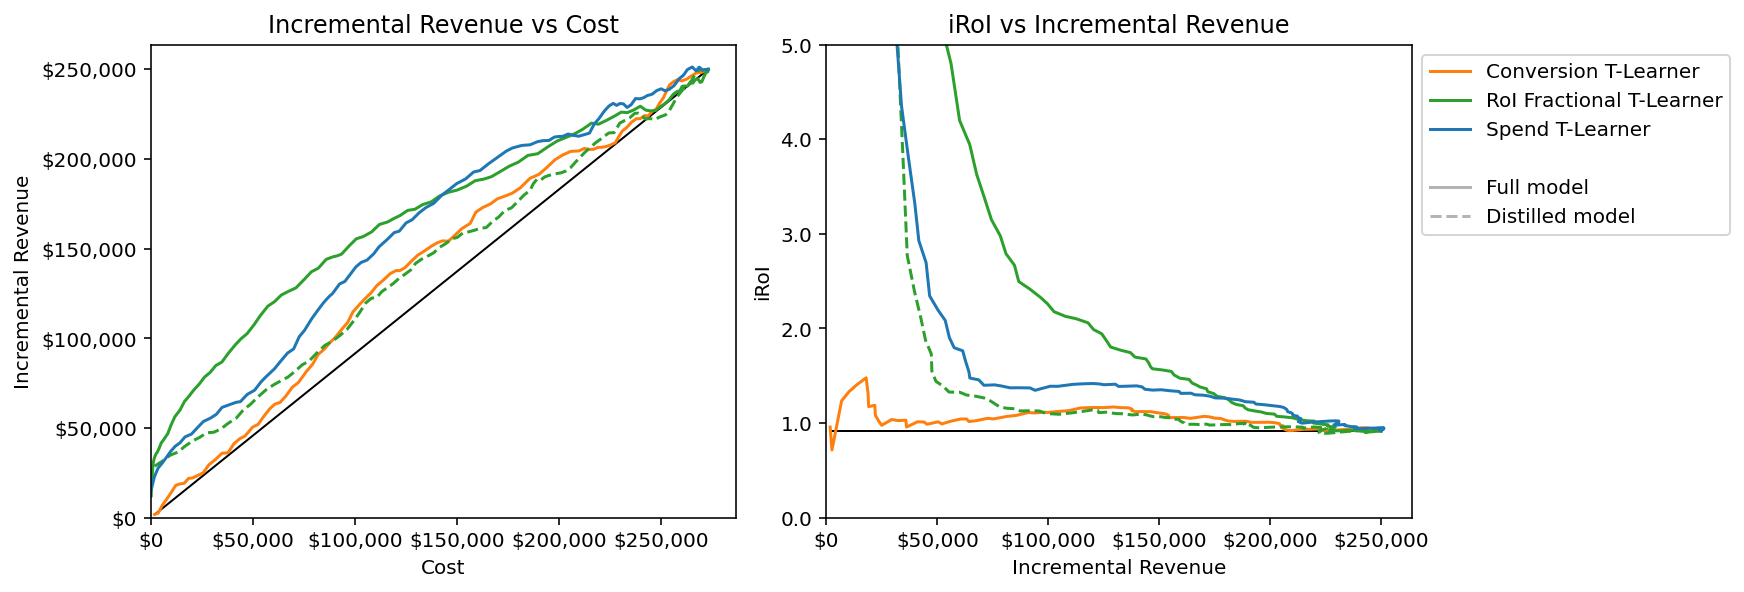

In [ ]:
class RoIUpliftEvaluator(fr.evaluate.UpliftEvaluator):
  def __init__(self, **kwargs):
    kwargs["metric_cols"] = ["spend", "conversion", "cost"]
    super().__init__(**kwargs)

  def _calculate_composite_metrics(self, data: pd.DataFrame) -> pd.DataFrame:
    data["roi__inc_cum"] = data["spend__inc_cum"] / data["cost__inc_cum"]
    data["roi__inc"] = data["spend__inc"] / data["cost__inc"]
    return data

evaluator = RoIUpliftEvaluator(
    is_treated_col="treatment",
    treatment_propensity_col="treatment_propensity",
    effect_type=fr.EffectType.ATE
)

models = {
    "spend_t_learner_score": "Spend T-Learner",
    "conversion_t_learner_score": "Conversion T-Learner",
    "roi_score": "RoI Fractional T-Learner",
    "roi_score_distill": "RoI Fractional T-Learner",
}

results = evaluator.evaluate(criteo.test_data, score_cols=list(models.keys()))

fig, axs = plt.subplots(ncols=2, figsize=(12, 4), constrained_layout=True)

plot_cumulative_incrementality(
    axs[0],
    results,
    title="Incremental Revenue vs Cost",
    model_names=models,
    x_col="cost__inc_cum",
    y_col="spend__inc_cum",
    x_label="Cost",
    y_label="Incremental Revenue",
    x_format="${:,.0f}",
    y_format="${:,.0f}",
    show_legend=False,
    x_lim=[0, None],
    y_lim=[0, None],
)

plot_cumulative_incrementality(
    axs[1],
    results,
    title="iRoI vs Incremental Revenue",
    model_names=models,
    x_col="spend__inc_cum",
    y_col="roi__inc_cum",
    x_label="Incremental Revenue",
    y_label="iRoI",
    x_format="${:,.0f}",
    y_format="{:.1f}",
    x_lim=[0, None],
    y_lim=[0, 5]
)

plt.show()

Again the fractional uplift model clearly outperforms the regular uplift models. In this case the regular spend T-Learner also does quite well, but clearly not as well as the RoI fractional learner. It seems that the distilled version doesn't match the full model well here, so would clearly need some more tuning.

### Objective 3: Maximum Incremental Conversions with an RoI Constraint

The final case we will test is the case where we are trying to deliver the most incremental conversions as possible, while ensuring that the iRoI does not drop below some iRoI target. In this example we will set the iRoI target = 2.0.

#### Fractional uplift model

This problem is a bit more complicated because it has a constraint, but it can be solved using fractional uplift by setting:

* Maximize KPI ($\alpha$) = Conversion
* Constraint KPI ($\beta$) = Cost
* Constraint Offset KPI ($\gamma$) = Spend
* Constraint Offset Scale ($\delta$) = iRoI Target

This setup means the uplift model estimates the following quantity:

$$
f_\delta(X)=
\begin{cases}
    \frac{N_{\text{convert}, \, T=1} - N_{\text{convert}, \, T=0}}{\text{Cost}_{T=1} - \frac{\text{Spend}_\text{T=1} - \text{Spend}_\text{T=0}}{\text{iRoI}_\text{target}}},& \text{Cost}_{T=1} > \frac{\text{Spend}_\text{T=1} - \text{Spend}_\text{T=0}}{\text{iRoI}_\text{target}}\\
    \infty,              & \text{otherwise}
\end{cases}
$$

This can be thought of as:

1. If a user has an iRoI above the iRoI target, always target them.
2. If they have an iRoI below the iRoI target, order them by the amount of incremental conversions they bring, divided by the net cost, where the net cost is the cost above the iRoI target. Target the users who bring the most incremental conversions while hurting the iRoI target the least.

This is implemented below:

In [ ]:
target_roi = 2.0

train_data = fr.datasets.PandasTrainData(
    features_data=criteo.train_data[criteo.features],
    maximize_kpi=criteo.train_data["conversion"].values,
    constraint_kpi=criteo.train_data["cost"].values,
    constraint_offset_kpi=criteo.train_data["spend"].values,
    is_treated=criteo.train_data["treatment"].values,
    treatment_propensity=criteo.train_data["treatment_propensity"].values,
    sample_weight=criteo.train_data["sample_weight"].values,
    shuffle_seed=1234
)
fractional_t_learner = fr.meta_learners.FractionalLearner(get_base_regressor())
fractional_t_learner.fit(train_data)

distill_fractional_t_learner = get_base_regressor()
fractional_t_learner.distill(distill_dataset, distill_fractional_t_learner, constraint_offset_scale=target_roi)

criteo.test_data[f"roi_constrained_conversion_score"] = fractional_t_learner.predict(
    test_dataset, constraint_offset_scale=target_roi
)
criteo.test_data[f"roi_constrained_conversion_score_distill"] = distill_fractional_t_learner.predict(test_dataset)

21/21 [==============================] - 0s 10ms/step


#### Evaluation

To evaluate this, we are looking for the maximum conversions where iRoI is equal to the iRoI target, 2.0. Below I use the uplift evaluator again to plot iRoI as a function of incremental conversions.  

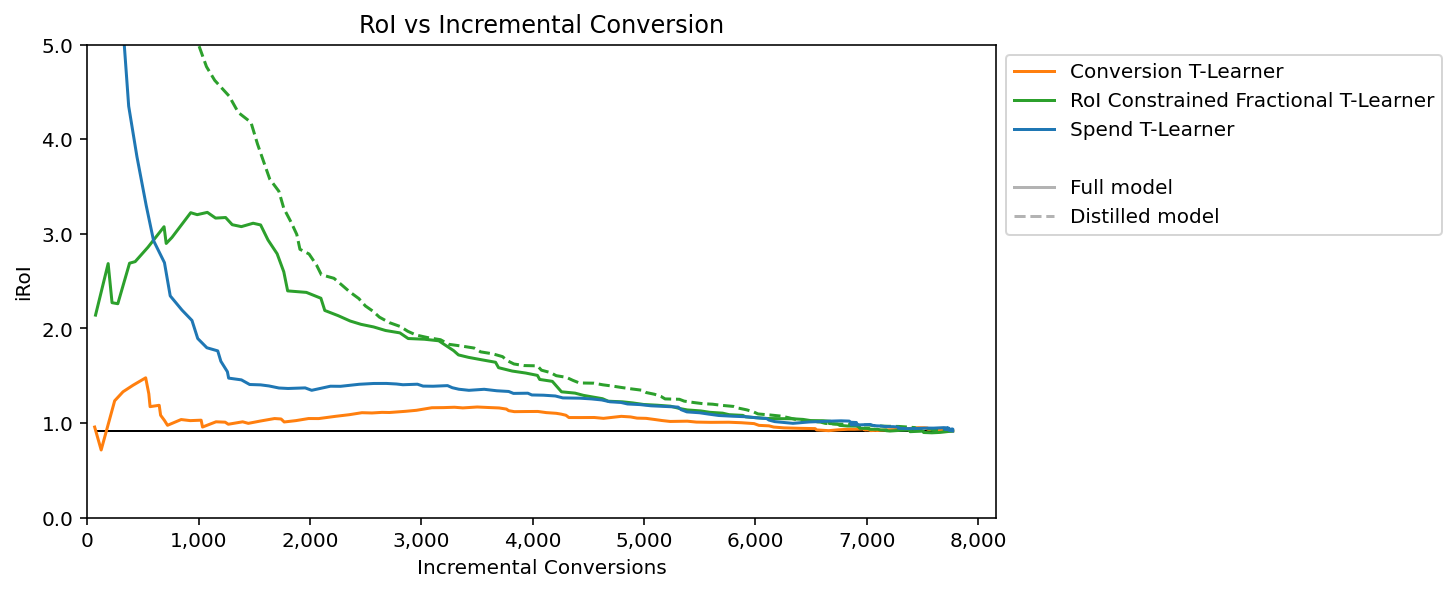

In [ ]:
evaluator = RoIUpliftEvaluator(
    is_treated_col="treatment",
    treatment_propensity_col="treatment_propensity",
    effect_type=fr.EffectType.ATE
)

models = {
    "spend_t_learner_score": "Spend T-Learner",
    "conversion_t_learner_score": "Conversion T-Learner",
    "roi_constrained_conversion_score": "RoI Constrained Fractional T-Learner",
    "roi_constrained_conversion_score_distill": "RoI Constrained Fractional T-Learner",
}

results = evaluator.evaluate(criteo.test_data, score_cols=list(models.keys()))

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

roi_plot = plot_cumulative_incrementality(
    ax,
    results,
    title="RoI vs Incremental Conversion",
    model_names=models,
    x_col="conversion__inc_cum",
    y_col="roi__inc_cum",
    x_label="Incremental Conversions",
    y_label="iRoI",
    x_format="{:,.0f}",
    y_format="{:.1f}",
    x_lim=[0, None],
    y_lim=[0, 5]
)

plt.show()

It's clear again that the fractional learner outperforms the simple T-learners, delivering ~3000 incremental conversions with an iRoI = 2.0. The regular conversion T-Learner **never** manage to achieve an iRoI of 2.0, while the spend T-Learner can only deliver ~1000 incremental conversion with an iRoI of 2.0.

## Exporting Models

In this notebook we have explored how fractional uplift modelling can be used to optimise for different objectives, and how it outperforms regular uplift models in each case.

Now if you want to deploy a fractional uplift model, the easiest way to do this is to export the distilled model and then save that somewhere. Exporting a model will return whatever the base model is, so saving it will depend on what base model you are using. Below you can see how it works for tensorflow decision forests.

In [ ]:
exported_model = distill_fractional_t_learner.export()
print(type(exported_model))

# Now I save it. This line might be different if you use something different to tensorflow.
exported_model.save("/tmp/my_saved_model")

<class 'google3.third_party.tensorflow_decision_forests.keras.GradientBoostedTreesModel'>


In [ ]:
!ls /tmp/my_saved_model

assets
fingerprint.pb
keras_metadata.pb
saved_model.pb
variables
